<h1> Stock Market Graph Analysis </h1>

In [2]:
library('igraph')
library('dplyr')
library('anytime')

In [3]:
num_days = 765
list_files <- list.files(path = "finance_data/data/", pattern = "*.csv")

<h2> Helper Functions </h2>

In [4]:
get_return = function(a, unnormalize = FALSE){
    
    pi_t = a
    
    pi_t_1 = c(pi_t[1], pi_t)
    pi_t_1 = pi_t_1[1:(length(pi_t_1)-1)]
    
    qi_t = (pi_t - pi_t_1) / pi_t_1
    
    r_t = log(1 + qi_t)
    
    if(unnormalize)
        return(qi_t)
    else
        return(r_t)
}

In [5]:
get_correlation = function(i, j){
    
    num = mean(i*j) - mean(i) * mean(j)
    den = (mean(i^2) - mean(i)^2) * (mean(j^2) - mean(j)^2)
    return(num / sqrt(den))
    
}

In [6]:
get_edge_list = function(stock_returns, file_name){
    
    
    file.create(file_name)
    stocks <- names(stock_returns)
    edge_list <- data.frame(matrix(ncol = 3, nrow = 0))
    x <- c("stock_i", "stock_j", "weight")
    colnames(edge_list) <- x

    for(i in 1:(length(stocks)-1)){
        for(j in (i+1):length(stocks)){
            corr = get_correlation(stock_returns[[i]], stock_returns[[j]])
            weight = sqrt(2*(1 - corr))
            #edge_list <- rbind(edge_list, data.frame("stock_i" = stocks[i],  "stock_j" = stocks[j], "weight" = weight))
            cat(paste(stocks[i],stocks[j],weight,"\n",sep = "\t"), file = file_name, append = TRUE)
            
        }
    }
}

In [7]:
get_stock_returns = function(unnormalize_flag = FALSE){
    
    stock_returns <- list()

    for(file_name in list_files){

        stock <- read.csv(paste("finance_data/data/", file_name, sep = ""))
        close <- unlist(stock['Close'])

        if(length(close) == num_days)
            stock_returns[[gsub(pattern = "\\.csv$", "", file_name)]] <- get_return(close, unnormalize =  unnormalize_flag)
    }

        return(stock_returns)

}

In [83]:
get_edge_list(get_stock_returns(), "stock_edge_list.txt")

In [4]:
edge_list <- as.matrix(read.table('stock_edge_list.txt', sep = "\t", 
                                         header = FALSE, quote = "", check.names = FALSE))
colnames(edge_list) = c("stock_i", "stock_j", "weight", "\t")
stock_network = graph.data.frame(edge_list, directed=FALSE)

<h2> Graph Properties </h2>

In [5]:
cat("Is graph weighted? ", is_weighted(stock_network))
cat("\nNumber of edges in the correlation graph = ", length(E(stock_network)))
cat("\nNumber of vertices in the correlation graph = ", length(V(stock_network)))

Is graph weighted?  TRUE
Number of edges in the correlation graph =  121771
Number of vertices in the correlation graph =  494

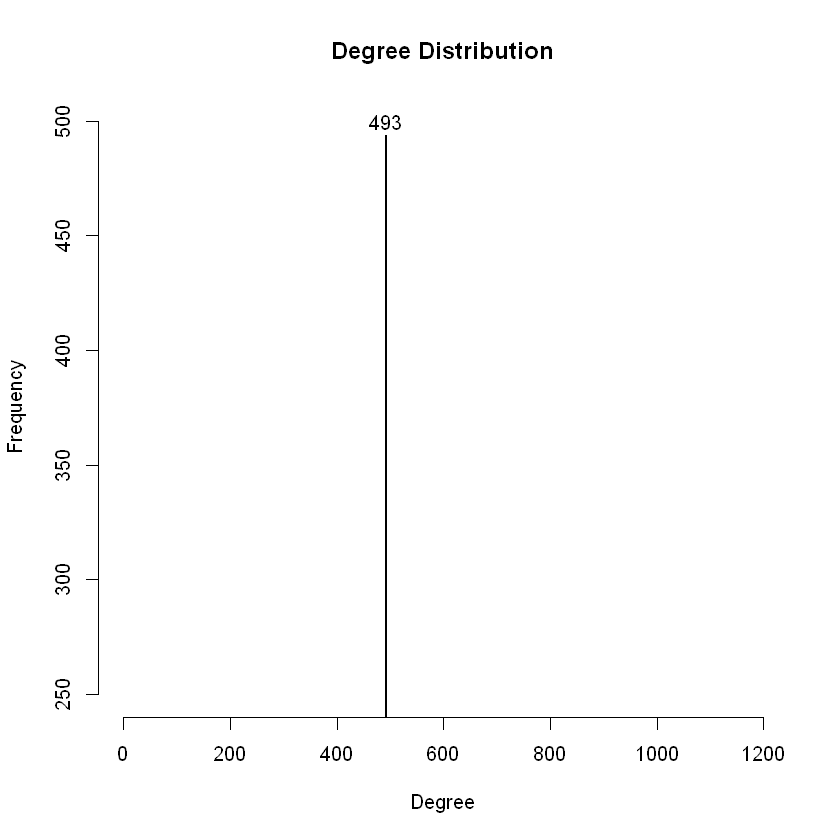

In [13]:
degree_distribution <- degree(stock_network)
histogram <- hist(degree_distribution, breaks=seq(from=490, to=500, by=1),
                  xlim=c(0,1200), ylim=c(250,500), 
                  xlab="Degree",ylab="Frequency", main="Degree Distribution")
text(histogram$mids,histogram$counts-1,labels=histogram$counts-1, adj=c(0.5, -0.5))